In [ ]:
from google.colab import drive
drive.mount('/gdrive') ## a verification link will pop-up requiring mounting permission
from google.colab import auth
auth.authenticate_user()   ## a verification link will pop-up requiring Cloud Access permission

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
from google.colab import auth
auth.authenticate_user()

%cd /gdrive/My\ Drive/segmentation

import tensorflow as tf 
print ('Tensorflow version: ', tf.__version__) ##please be noted that our code is written in TF2.3, and may not be compatible for other TF version
import time

batch_size = 128
num_classes=14

# Create a dictionary describing the features.
image_feature_description = {
    'rgb': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.string),
    'x': tf.io.FixedLenFeature([], tf.string),
    'y': tf.io.FixedLenFeature([], tf.string),
    'z': tf.io.FixedLenFeature([], tf.string),
    'weight': tf.io.FixedLenFeature([num_classes],tf.float32),
}
## flip the image horizontally
def flip(image):
    return tf.image.flip_left_right(image)

def subtract(image):
    return tf.math.subtract(tf.ones(tf.shape(image))*255,image)

#we resize the image to (480,460) since we want it to be compatible to the frauas dataset later
def crop(img,height,width,x1,y1):
    img = img[y1:y1+height, x1:x1+width,:]
    img = tf.image.resize(img,(480,640))
    return img

#to rescale image back to [0,1] range
def rescale(x):
    x = tf.cast(x,tf.float32)
    max_val = tf.reduce_max(x)
    min_val = tf.reduce_min(x)
    return (x-min_val)/(max_val-min_val+1e-7)

#blur the image by sliding a Gaussian kernel accross it
def gaussian_blur(img, kernel_size=7, sigma=5):
    def gauss_kernel(channels, kernel_size, sigma):
        
        ax = tf.range(-tf.cast(tf.math.floordiv(kernel_size,2),tf.int32) + 1, 
                      tf.cast(tf.math.floordiv(kernel_size,2),tf.int32) + 1)  
           
        xx, yy = tf.meshgrid(ax, ax)
        yy = tf.cast(yy,tf.int32)
        kernel = tf.exp(-(tf.cast(xx ** 2,tf.float32) + tf.cast(yy ** 2,tf.float32)) / (2 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel

    img = tf.cast(tf.expand_dims(img,axis=0),tf.float32)
    gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]
    gaussian_kernel = tf.cast(gaussian_kernel,tf.float32)
    
    img = tf.nn.depthwise_conv2d(img, gaussian_kernel, [1, 1, 1, 1],
                                  padding='SAME', data_format='NHWC')
    img = tf.cast(tf.squeeze(img),tf.float32)

    return img

#parse function for training data
def train_parse(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
    data = tf.io.parse_single_example(example_proto, image_feature_description)
    rgb = tf.image.decode_jpeg(data['rgb'])
    label = tf.image.decode_png(data['label'],dtype=tf.uint8)
    x = tf.image.decode_jpeg(data['x'])
    y = tf.image.decode_jpeg(data['y'])
    z = tf.image.decode_jpeg(data['z'])
    weight = data['weight']
    
    ##scenenet image's resolution are 240x320
    rgb = tf.reshape(rgb,(240,320,3))       
    label = tf.reshape(label,(240,320,1))
    x = tf.reshape(x,(240,320,1))
    y = tf.reshape(y,(240,320,1))
    z = tf.reshape(z,(240,320,1))
    weight = tf.reshape(weight,[num_classes,])

    ##generate random crop coordinates
    fraction = tf.random.uniform([],0.7,1.0)    #we only crop at least 50% of the image
    height = tf.cast(240*fraction,tf.int32)
    width = tf.cast(320*fraction,tf.int32)
    y1 = tf.random.uniform([],0,240-height,dtype=tf.int32)
    x1 = tf.random.uniform([],0,320-width,dtype=tf.int32)

    ##crop out the patch
    rgb = crop(rgb,height,width,x1,y1)
    x = crop(x,height,width,x1,y1)
    y = crop(y,height,width,x1,y1)
    z = crop(z,height,width,x1,y1)
    label = crop(label,height,width,x1,y1)

    rgb = tf.cast(rgb,tf.float32)
    label = tf.cast(label,tf.float32)
    x = tf.cast(x,tf.float32)
    y = tf.cast(y,tf.float32)
    z = tf.cast(z,tf.float32)

    ##random flipping
    a = tf.random.uniform([],0.0,1.0)
    rgb = tf.cond(tf.math.greater(a,0.5),lambda: flip(rgb), lambda : rgb)
    x = tf.cond(tf.math.greater(a,0.5),lambda: flip(x), lambda : x)
    y = tf.cond(tf.math.greater(a,0.5),lambda: flip(y), lambda : y)
    z = tf.cond(tf.math.greater(a,0.5),lambda: flip(z), lambda : z)
    label = tf.cond(tf.math.greater(a,0.5),lambda: flip(label), lambda : label)
    x = tf.cond(tf.math.greater(a,0.5),lambda: subtract(x), lambda : x)        #we need to subtract it to make sure that the left pixels are smaller than the right pixels

    ## adding random gaussian noises to points cloud
    noise_x = tf.random.normal(tf.shape(x), 0, 5)
    noise_y = tf.random.uniform(tf.shape(y), 0, 5)
    noise_z = tf.random.uniform(tf.shape(z), 0, 5)
    x = x+noise_x
    y = y+noise_y
    z = z+noise_z
   
    ## data augmentation
    saturation = tf.random.uniform([],0.5,3)
    contrast = tf.random.uniform([],0.5,2.5)
    brightness = tf.random.uniform([],-0.2,0.2)
    hue = tf.random.uniform([],-0.9,0.9)
    kernel_size = tf.random.uniform([],1,3,dtype=tf.int32)*2+1 ##kernel size for blurring

    saturation = tf.squeeze(saturation)
    contrast = tf.squeeze(contrast)
    brightness = tf.squeeze(brightness)
    hue = tf.squeeze(hue)

    rgb = tf.image.adjust_brightness(rgb, brightness)
    rgb = tf.image.adjust_saturation(rgb, saturation)
    rgb = tf.image.adjust_contrast(rgb,contrast)
    hue = tf.image.adjust_hue(rgb,hue)
    blur_prob = tf.random.uniform([],0.0,0.7)
    rgb = tf.cond(tf.math.greater(blur_prob,0.5),lambda: gaussian_blur(rgb, kernel_size=kernel_size), lambda : rgb)
    
    ## creating penalizing weights (optional, might comment out)
    weight = tf.reshape(weight,(1,1,num_classes))
    label1 = tf.one_hot(tf.cast(label,tf.uint8),num_classes)
    label1 = tf.squeeze(label1)
    weight = tf.tile(weight,(tf.shape(x)[0],tf.shape(x)[1],1))
    weight = tf.math.multiply(weight,label1)
    weight = tf.reduce_sum(weight,axis=-1)
    weight = tf.reshape(weight,(tf.shape(x)[0],tf.shape(x)[1],1))

    rgb = rgb/255
    x = rescale(x)
    y = rescale(y)
    z = rescale(z)
    weight = rescale(weight)*10+1e-2

    imgs = tf.concat([rgb,x,y,z],axis=-1)
    imgs = tf.image.resize(imgs,(480,640))

    label = tf.one_hot(tf.cast(label,tf.int32),num_classes) ##one-hot the label since TPU requires this
    label = tf.squeeze(label)
    label= tf.image.resize(label,(480,640))
    label = tf.cast(tf.math.round(label),tf.float32)
    weight = tf.image.resize(weight,(480,640))
    labels = tf.concat([label,weight],axis=-1)

    return imgs,labels


##parsing function for validation set
def val_parse(example_proto):
    data = tf.io.parse_single_example(example_proto, image_feature_description)
    rgb = tf.image.decode_jpeg(data['rgb'])
    label = tf.image.decode_png(data['label'],dtype=tf.uint8) 
    x = tf.image.decode_jpeg(data['x'])
    y = tf.image.decode_jpeg(data['y'])
    z = tf.image.decode_jpeg(data['z'])
    weight = data['weight']
    
    rgb = tf.reshape(rgb,(240,320,3))
    label = tf.reshape(label,(240,320,1))
    x = tf.reshape(x,(240,320,1))
    y = tf.reshape(y,(240,320,1))
    z = tf.reshape(z,(240,320,1))
    weight = tf.reshape(weight,[num_classes,])

    weight = tf.reshape(weight,(1,1,num_classes))
    label1 = tf.one_hot(tf.cast(label,tf.uint8),num_classes)
    label1 = tf.squeeze(label1)
    weight = tf.tile(weight,(tf.shape(x)[0],tf.shape(x)[1],1))
    weight = tf.math.multiply(weight,label1)
    weight = tf.reduce_sum(weight,axis=-1)
    weight = tf.reshape(weight,(tf.shape(x)[0],tf.shape(x)[1],1))

    rgb = tf.cast(rgb,tf.float32)
    label = tf.cast(label,tf.float32)
    x = tf.cast(x,tf.float32)
    y = tf.cast(y,tf.float32)
    z = tf.cast(z,tf.float32)

    rgb = rgb/255
    x = rescale(x)
    y = rescale(y)
    z = rescale(z)
    weight = rescale(weight)*10+1e-2

    imgs = tf.concat([rgb,x,y,z],axis=-1)
    imgs = tf.image.resize(imgs,(480,640))

    label = tf.one_hot(tf.cast(label,tf.int32),num_classes)
    label = tf.squeeze(label)
    label= tf.image.resize(label,(480,640))
    label = tf.cast(tf.math.round(label),tf.float32)
    weight = tf.image.resize(weight,(480,640))
    labels = tf.concat([label,weight],axis=-1)
    
    return imgs,labels

##remember to change the bucket name to yours
cloud_bucket = 'segmentation_scenenet'
filenames = [f'gs://{cloud_bucket}/train_scenenet_{i}.tfrecords' for i in range(17)]
train =tf.data.Dataset.from_tensor_slices(filenames)
train = train.shuffle(100).interleave(lambda x:tf.data.TFRecordDataset(x).map(train_parse).repeat(),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size,drop_remainder=True).prefetch(100).repeat()

##remember to change the bucket name to yours
filenames = f'gs://{cloud_bucket}/val_scenenet.tfrecords'
val = tf.data.TFRecordDataset(filenames).map(val_parse,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size,drop_remainder=True).prefetch(100)


/gdrive/.shortcut-targets-by-id/1klcB2acXgXP_amwPhBA9lVepld7KtCt8/thesis


In [ ]:
import os
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

dp=0.1

## orginal HarDNet can be found here, but in pytorch: https://github.com/PingoLH/FCHarDNet/blob/master/ptsemseg/models/hardnet.py 
def get_link(layer, base_ch, growth_rate, grmul):
    if layer == 0:
        return base_ch, 0, []
    out_channels = growth_rate
    link = []
    
    for i in range(10):
        dv = 2 ** i
        if layer % dv == 0:
            k = layer - dv
            link.append(k)
            if i > 0:
                out_channels *= grmul
    
    out_channels = int(int(out_channels + 1) / 2) * 2
    
    return out_channels, link

def conv(x, depth, kernel_size=3, strides=1, padding = 'same',trainable=True):
    return tf.keras.layers.Conv2D(depth, (kernel_size,kernel_size), (strides,strides), padding= padding,
                                  kernel_initializer = tf.initializers.he_uniform(seed = 1),trainable=trainable)(x)

def batch_norm(x, trainable=True):
    return tf.keras.layers.BatchNormalization(fused=True,trainable=trainable)(x)

def relu(x):
    return tf.nn.relu(x)

def resize(x, size):
    return tf.image.resize(x, size)

def drop_out(x):
    return tf.keras.layers.Dropout(dp)(x)

def avg_pool(x, pool_size = 2, strides = 2):
    return tf.keras.layers.AveragePooling2D(pool_size, strides, padding = 'same')(x)

def conv_layer(x, depth, kernel_size=3, strides=1,trainable=True,dropout=True):
    x = conv(x, depth = depth, kernel_size=kernel_size, strides=strides,trainable=trainable)
    x = batch_norm(x)
    x = relu(x)
    if dropout:
        x = drop_out(x)   
    return x

def hardblock(x, in_channels, growth_rate, grmul, n_layers,trainable=True,dropout=True):
    layers = [x]
    out_layers = []
    out_channels = 0
    
    for i in range(n_layers):    
        links = []
        out_ch, link = get_link(i+1, in_channels, growth_rate, grmul)
    
        for i in link:
            links.append(layers[i])

        x = tf.concat(links, axis = -1)
        layers.append(conv_layer(x, out_ch,trainable=trainable,dropout=dropout))
    
    for i in range(len(layers)):
        if (i == len(layers)-1) or (i%2 == 1):
            out_layers.append(layers[i])  
    x = tf.concat(out_layers, axis = -1)
    return x

def transition_up(x, skip_connection):
    x = resize(x, (tf.shape(skip_connection)[1], tf.shape(skip_connection)[2]))
    x = tf.concat([x, skip_connection], axis = -1)
    return x

##squeeze and excitation block comes from EfficientNet: https://github.com/qubvel/efficientnet/blob/master/efficientnet/model.py
def se_block(x,trainable=True):
    num_reduced_filters = tf.cast(x.shape[-1]*0.25,tf.int32).numpy()
    se_tensor = layers.GlobalAveragePooling2D()(x)
    se_tensor = layers.Reshape((1, 1, x.shape[-1]))(se_tensor)
    se_tensor = layers.Conv2D(num_reduced_filters, 1, activation=tf.keras.activations.swish, padding='same',trainable=trainable,
                              kernel_initializer = tf.initializers.he_uniform(seed = 1))(se_tensor)
    se_tensor = layers.Conv2D(x.shape[-1],1,activation='sigmoid',padding='same',trainable=trainable,
                              kernel_initializer = tf.initializers.he_uniform(seed = 1))(se_tensor)
    x = layers.multiply([x, se_tensor])   
    return x

def hardnet(img):
    encoder_trainable_rgb=True 
    encoder_trainable_depth = True
    depth = img[:,:,:,3:]
    rgb = img[:,:,:,:3]
    first_ch  = np.asarray([16,24,32,48])
    depth_conv1 = np.asarray([64, 96, 160, 224, 320])
    grmul = 1.7
    gr       = np.asarray([  10,16,18,24,32])
    n_layers = [4, 4, 8, 8, 8]
    up_sample = np.asarray([126,238,374,534])
    skip_connections = []
    skip_connections_d = []
    blks = len(n_layers)
    
    x = rgb
    x = conv_layer(x, first_ch[0], strides = 2,trainable=encoder_trainable_rgb)
    x = conv_layer(x, first_ch[1],trainable=encoder_trainable_rgb)
    x = conv_layer(x, first_ch[2], strides = 2,trainable=encoder_trainable_rgb)
    x = conv_layer(x, first_ch[3],trainable=encoder_trainable_rgb)

    
    x_d = depth
    x_d = conv_layer(x_d, first_ch[0], strides = 2,trainable=encoder_trainable_depth)
    x_d = conv_layer(x_d, first_ch[1],trainable=encoder_trainable_depth)
    x_d = conv_layer(x_d, first_ch[2], strides = 2,trainable=encoder_trainable_depth)
    x_d = conv_layer(x_d, first_ch[3],trainable=encoder_trainable_depth)
    
    ch = first_ch[3]
    ch_d = first_ch[3]
    for i in range(blks):
        x = hardblock(x, ch, gr[i], grmul, n_layers[i],trainable=encoder_trainable_rgb)
        x_d = hardblock(x_d, ch_d, gr[i], grmul, n_layers[i],trainable=encoder_trainable_depth)
        
        if i < blks-1:
            skip_connections.append(tf.math.add(se_block(x,trainable=encoder_trainable_rgb),se_block(x_d,trainable=encoder_trainable_depth))) 
        x = conv_layer(x, x.shape[-1], kernel_size = 1,trainable=encoder_trainable_rgb)
        x_d = conv_layer(x_d, x_d.shape[-1], kernel_size = 1,trainable=encoder_trainable_depth)
        if i < blks-1:
            x = avg_pool(x)
            x_d = avg_pool(x_d)
        ch = x.shape[-1]
        ch_d = x_d.shape[-1]
    
    x = tf.math.add(se_block(x,trainable=encoder_trainable_rgb),se_block(x_d,trainable=encoder_trainable_depth))

    n_blocks = blks-1
    for i in range(n_blocks-1,-1,-1):
        skip = skip_connections.pop()
        x = transition_up(x, skip)

        cur_channels_count = x.shape[-1]//2

        x = conv_layer(x, cur_channels_count, kernel_size=1,dropout=False)
        x = hardblock(x, cur_channels_count, gr[i], grmul, n_layers[i],dropout=False)

    x_pre_conv = x
    x = conv(x, depth = 14, kernel_size = 1)
    x = resize(x, (img.shape[1],img.shape[2]))
    
    return x


/gdrive/.shortcut-targets-by-id/1klcB2acXgXP_amwPhBA9lVepld7KtCt8/thesis


In [ ]:
import tensorflow as tf
import numpy as np


def custom_metrics(y_true,y_pred):
    total_iou = tf.constant(0.)
    y_true = y_true[:,:,:,:-1]
    for label in range(num_classes):
        true = tf.cast(tf.equal(tf.math.argmax(y_true,axis=-1), label),tf.int32)
        pred = tf.cast(tf.equal(tf.math.argmax(y_pred,axis=-1), label),tf.int32)
        intersection = tf.reduce_sum(true * pred)
        union = tf.reduce_sum(true) + tf.reduce_sum(pred) - intersection
        intersection=tf.cast(intersection,tf.float32)
        union=tf.cast(union,tf.float32)
        total_iou = total_iou + tf.cond(tf.math.equal(union, 0), lambda : 1.0, lambda : intersection / union)
    return total_iou / num_classes


def custom_loss(y_true,y_pred):
    weight = y_true[:,:,:,-1]
    y_true = y_true[:,:,:,:-1]
    weight = tf.expand_dims(weight,axis=-1)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
    #loss1 = loss(y_true, y_pred, sample_weight=weight)
    
    loss1 = tf.reduce_mean(loss1)

    prob = tf.nn.softmax(y_pred)
    num = tf.reduce_sum(prob*y_true,axis=-1)
    denom = tf.reduce_sum(prob + y_true-prob*y_true,axis=-1)+1e-7
    loss2 = 1 - num/denom
    loss2 = tf.expand_dims(loss2,axis=-1)
    loss2 = tf.reduce_mean(loss2*weight) ##you may play around by disabling the class weights, which is originally used to combat class imbalance
    #loss2 = tf.redice_mean(loss2) ##uncomment this and comment line abovr to disable class weight
    
    return loss1 + loss2


with strategy.scope():
    input = tf.keras.layers.Input(shape=(480,640,6))
    output = hardnet(input)
    model = tf.keras.Model(inputs=input, outputs=output)
 

In [ ]:
%cd /gdrive/My\ Drive/thesis

##toggle these options for resume training process
continue_training = False
starting_epoch = 0
checkpoint_path = ''

def scheduler(epoch):
    epoch = epoch+starting_epoch
    if 0.002/(0.2*epoch+1) > 0.0001:
        return 0.002/(0.2*epoch+1)
    else:
        return 0.0001

with strategy.scope():
    checkpoint_filepath = './weights_scenenet/{loss:.2f}_{val_custom_metrics:.2f}.h5'
    ##configure the model training and validation policies
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss=custom_loss, metrics=custom_metrics)
    if continue_training:
        model.load_weights(checkpoint_path)
    ##save only best checkpoints
    cb_list = [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,save_best_only = True, monitor = 'val_custom_metrics',verbose=1,mode='max'),
            tf.keras.callbacks.LearningRateScheduler(scheduler)]
    model.fit(train,epochs = 1000,steps_per_epoch=1500,validation_data=val,callbacks=cb_list,verbose=1)


/gdrive/.shortcut-targets-by-id/1klcB2acXgXP_amwPhBA9lVepld7KtCt8/thesis
Epoch 1/1000
   2/1500 [..............................] - ETA: 10:57 - loss: 0.8627 - custom_metrics: 0.2479WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0124s vs `on_train_batch_end` time: 0.8608s). Check your callbacks.


1500/1500 [==============================] - ETA: 0s - loss: 0.3004 - custom_metrics: 0.2105
Epoch 00001: val_custom_metrics improved from -inf to 0.22418, saving model to ./weight_tpu/0.30_0.22.h5
1500/1500 [==============================] - 1976s 1s/step - loss: 0.3004 - custom_metrics: 0.2105 - val_loss: 1.5859 - val_custom_metrics: 0.2242
Epoch 2/1000
1500/1500 [==============================] - ETA: 0s - loss: 0.2802 - custom_metrics: 0.2413
Epoch 00002: val_custom_metrics improved from 0.22418 to 0.23266, saving model to ./weight_tpu/0.28_0.23.h5
1500/1500 [==============================] - 1914s 1s/step - loss: 0.2802 - custom_metrics: 0.2413 - val_loss: 1.5512 - val_custom_metrics: 0.2327
Epoch 3/1000
1500/1500 [==============================] - ETA: 0s - loss: 0.2695 - custom_metrics: 0.2539
Epoch 00003: val_custom_metrics did not improve from 0.23266
1500/1500 [==============================] - 1932s 1s/step - loss: 0.2695 - custom_metrics: 0.2539 - val_loss: 1.6075 - val_cus

In [ ]:
##load best model and create the validation set iterator 
checkpoint = ''
model.load_weights(checkpoint)
vals =iter(val)

In [ ]:
##code for evaluating the global and per-class IoU and accuracy score of the model on the validation set 
def numpy_metrics(y_pred, y_true, n_classes,void_labels):
    """
    Similar to theano_metrics to metrics but instead y_pred and y_true are now numpy arrays
    """

    y_pred = np.argmax(y_pred, axis=-1).flatten()
    y_true = y_true.flatten()

    # We use not_void in case the prediction falls in the void class of the groundtruth
    #not_void = ~ np.any([y_true == label for label in void_labels], axis=0)

    I = np.zeros(n_classes)
    U = np.zeros(n_classes)

    for i in range(n_classes):
        y_true_i = y_true == i
        y_pred_i = y_pred == i

        I[i] = np.sum(y_true_i & y_pred_i)
        U[i] = np.sum((y_true_i | y_pred_i))

    accuracy = np.sum(I) / 480/640
    return I, U, accuracy

acc_tot = 0
n_imgs = 0
I_tot = 0
U_tot = 0
vals =iter(val)
while 1:
    try:
        a,b = next(vals)
        output = model.predict_on_batch(a)
        gt = np.argmax(b[:,:,:,:14].numpy(),axis=-1)
        #output = tf.nn.softmax(output).numpy()
        I, U, acc = numpy_metrics(output, gt, 14,[11])
        I_tot += I
        U_tot += U
        acc_tot += acc 
        n_imgs += batch_size
    except:
        print('error')
        break

iou= np.mean(I_tot / (U_tot+1e-7))
accuracy = acc_tot / n_imgs
for label, jacc in zip(range(0,14), I_tot / U_tot):
    print('{} :\t{:.4f}'.format(label, jacc))
print ('Mean Jaccard', iou)
print ('Global accuracy', accuracy)

error
0 :	0.9182
1 :	0.3586
2 :	0.0000
3 :	0.6877
4 :	0.3412
5 :	0.6557
6 :	0.2232
7 :	0.4042
8 :	0.4049
9 :	0.0510
10 :	0.3318
11 :	0.2469
12 :	0.6708
13 :	0.1983
Mean Jaccard 0.392322962590473
Global accuracy 0.022827286824544223


(480, 640)


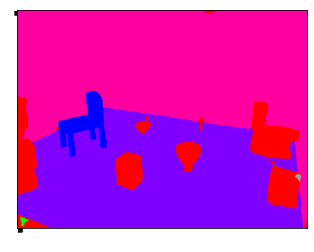

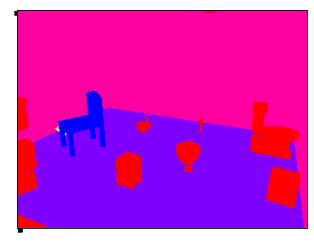

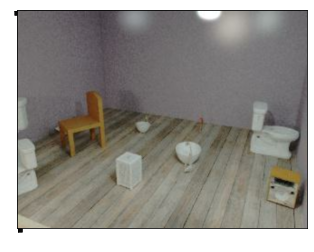

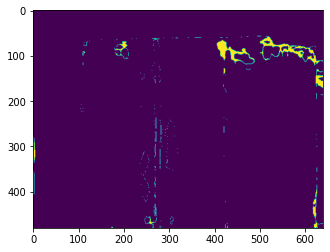

In [ ]:
##some code to visualize the output from the model

a,b = next(vals)
def labeller(img):
    label = img[:,:,np.newaxis]            
    label = np.tile(label,(1,1,3)).astype('uint8')
    label[label[:,:,0]==0]= [0,0,0]
    label[label[:,:,0]==1]=[255,255,50]
    label[label[:,:,0]==2]=[28,255,0]    
    label[label[:,:,0]==3]=[0,255,255]
    label[label[:,:,0]==4]=[0,0,255]
    label[label[:,:,0]==5]=[127,0,255]
    label[label[:,:,0]==6]=[160,160,160]
    label[label[:,:,0]==7]=[255,0,0]
    label[label[:,:,0]==8]=[255,255,255]
    label[label[:,:,0]==9]=[25,25,25]
    label[label[:,:,0]==10]=[0,255,0]
    label[label[:,:,0]==11]=[25,0,25]
    label[label[:,:,0]==12]=[255,0,160]
    label[label[:,:,0]==13]=[200,130,55]
    return label
output = model.predict_on_batch(a)
output = output[0]
output = tf.nn.softmax(output).numpy()
output = np.argmax(output,axis=-1)
output = labeller(output)
gt = np.argmax(b[0,:,:,:14],axis=-1)
print(gt.shape)
gt = labeller(gt)
def plotter(img):
    x = np.arange(10)
    y = np.arange(10)
    plt.xticks(x, " ")
    plt.yticks(y, " ")

    plt.imshow(img)
    plt.show()

plotter(output)
plotter(gt)
plotter(a[0,:,:,:3])